# Recreación de resultados previos
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

In [7]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
    
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.heasarc import Heasarc
from astroquery.esa.xmm_newton import XMMNewton

from src.gaia_dr3.etls.download_data import get_object, get_object_from_simbad, get_cluster, get_skycoords, get_object_from_heasarc
from src.gaia_dr3.etls.stadistics import get_uwe_from_gaia, get_u0_g_c, get_ruwe_from_gaia
from src.gaia_dr3.etls.utils import convert_mas_yr_in_km_s

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor


#Establecemos que las consultas de GAIA no tenga límites de filas
Gaia.ROW_LIMIT = -1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Tracing black holes in globular clusters with Gaia 

Empezaremos con los resultados presentados en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423), donde se detalla el objetivo final del proyecto: La obtención de un algoritmos capaz de detectar globulos candidatos a albergar un IMBH.

Para ello, se presenta como ejemplo de cúmulo 47 Tucanae (NGC 104), en el cual existen grandes indicios de la presencia de un agujero negro de masa intermedia (sobre $2300 M_\odot$ (Kızıltan et al., 2017)). Vamos a generar dos primeros catálogos
- GCngc104_r.vot: Todas las estrllas en GAIA DR3 dentro del radio del cluster Rc.
- GCngc104_6r.vot: Todas las estrllas en GAIA DR3 dentro de seis veces el radio del cluster (6Rc) y que cumplan:
    - pmra > 50 Km/s y pmdec > 50 Km/s.
    - valores positvos para el paralaje
    - Errores en el paralaje por debajo del 30%.

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Rc1: 40 elementos
Rc6: 3371 elementos


Text(0, 0.5, 'B')

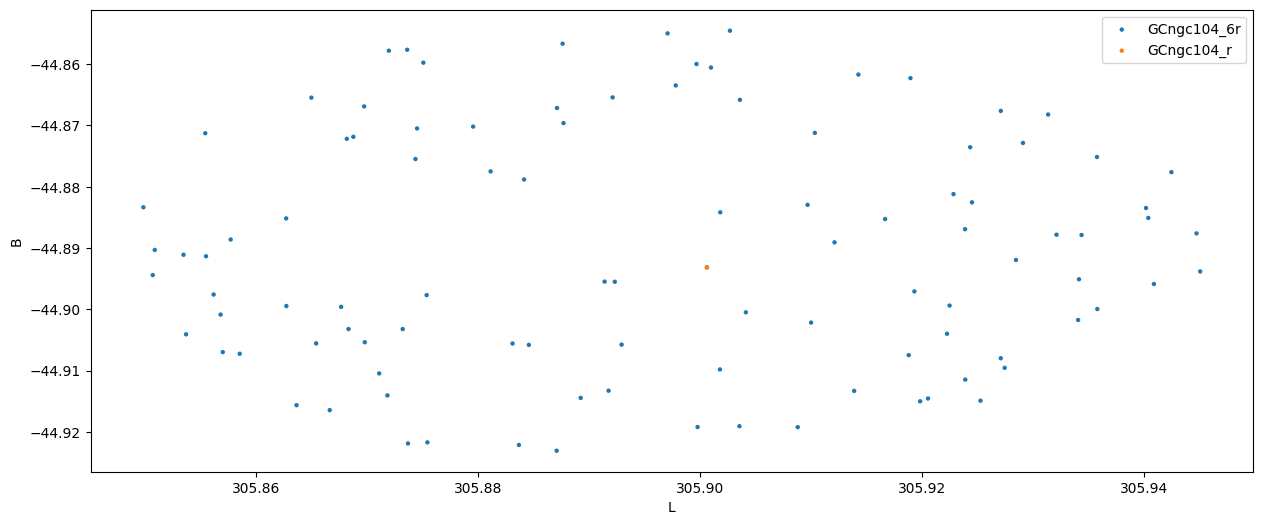

In [40]:
NAME_CLUSTER = "ngc104"
Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source" 

MIN_KPC = 3
MAX_KPC = 6

gc_r = get_cluster(NAME_CLUSTER, rc_scale=1)
gc_6r = get_cluster(NAME_CLUSTER, rc_scale=6)

df_r = gc_r.to_pandas()
df_6r = gc_6r.to_pandas()

print(f"Rc1: {df_r.shape[0]} elementos")
print(f"Rc6: {df_6r.shape[0]} elementos")

# Filtramos las estrellas según su paralaje
mask_r = (1 / df_r.parallax > 4) & (1 / df_r.parallax < 5)
mask_6r = (1 / df_6r.parallax > 4) & (1 / df_6r.parallax < 5)

df_r = df_r[mask_r]
df_6r = df_6r[mask_6r]
#Representamos las estrellas en sus coordenadas galacticas

fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(df_6r.l.values, df_6r.b.values, s=10, edgecolor='none', label="GCngc104_6r")
plt.scatter(df_r.l.values, df_r.b.values, s=10, edgecolor='none', label="GCngc104_r")
plt.legend()

# Etiquetas de los ejes
ax.set_xlabel('L')
ax.set_ylabel('B')


# Pruebas (BORRAR AL TERMINAR)

DF: 45871 elementos


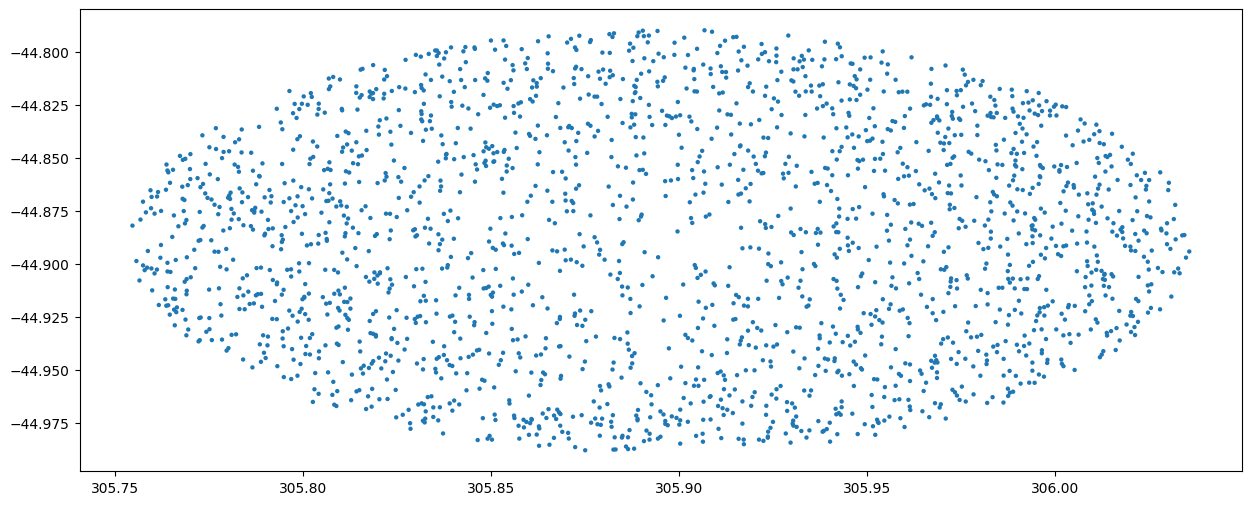

In [38]:
result_cluster = get_object_from_heasarc("ngc 104")
coords = get_skycoords(result_cluster, u.deg, u.deg)

radius = 6* u.arcmin
# job = Gaia.cone_search_async(coordinate=coords, radius=radius)
# results = job.get_results()


df = results.to_pandas()
mask = (1 / df.parallax > 4) & (1 / df.parallax < 5)

print(f"DF: {df.shape[0]} elementos")

#Representamos las estrellas en sus coordenadas galacticas

fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(df[mask].l.values, df[mask].b.values, s=10, edgecolor='none', label="test")

In [37]:
mask = (1 / df.parallax > 4) & (1 / df.parallax < 5)
1 / df.parallax[mask]

76       4.000518
78       4.011435
110      4.525307
116      4.630080
129      4.174044
           ...   
45789    4.491584
45820    4.268216
45824    4.460880
45844    4.906625
45851    4.406253
Name: parallax, Length: 2159, dtype: float64

In [28]:
heasarc = Heasarc()
mission = 'globclust'
result_cluster = heasarc.query_object(
    "ngc104", mission=mission, resultmax=10)

result_cluster

NAME,ALT_NAME,RA,DEC,VMAG,BV_COLOR,HELIO_DISTANCE,METALLICITY,SEARCH_OFFSET_
,,deg,deg,mag,mag,kpc,,
bytes9,bytes11,float64,float64,float64,float64,float64,float64,bytes15
NGC 104,47 Tuc,6.02363,-72.08128,3.95,0.88,4.5,-0.72,0.026 (ngc104)\n


## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.

In [104]:
coords = get_skycoords(result_cluster, u.deg, u.deg)
# Coordenadas aproximadas de NGC 104 (47 Tucanae)
ra = coords.ra.value  # Ascensión recta (RA) en grados
dec = coords.dec.value  # Declinación (Dec) en grados
radius = 4.2  # Radio de búsqueda en grados

job = Gaia.launch_job_async(f"""
SELECT * FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius})
) AND parallax > 0.09 AND parallax < 0.45 AND parallax_error < 0.30
""",dump_to_file=True, output_format='votable')
job

In [140]:
r = job.get_results()
df_or = r.to_pandas()
df_or

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,1635721458409799680,Gaia DR2 4690581681443189376,4690581681443189376,828625982,2015.5,15.918332,0.201866,-71.647040,0.188484,0.440600,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
1,1635721458409799680,Gaia DR2 4690573641262614912,4690573641262614912,414312991,2015.5,15.331154,0.177983,-71.769654,0.139487,0.436595,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
2,1635721458409799680,Gaia DR2 4690579894735823744,4690579894735823744,342496704,2015.5,15.609533,0.182285,-71.718707,0.171303,0.239275,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
3,1635721458409799680,Gaia DR2 4690581784522434176,4690581784522434176,1518833829,2015.5,15.834293,0.219158,-71.642171,0.212976,0.186520,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
4,1635721458409799680,Gaia DR2 4690583953494412160,4690583953494412160,1467977009,2015.5,15.328546,0.258090,-71.658827,0.217699,0.128899,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353161,1635721458409799680,Gaia DR2 4685927620530018304,4685927620530018304,174440426,2015.5,12.474862,0.235532,-73.350492,0.167881,0.336950,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
353162,1635721458409799680,Gaia DR2 4685926452361778304,4685926452361778304,1276913100,2015.5,12.051132,0.214518,-73.396768,0.185530,0.243711,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
353163,1635721458409799680,Gaia DR2 4685925941249732992,4685925941249732992,744242744,2015.5,12.212076,0.284050,-73.407428,0.253370,0.306156,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,
353164,1635721458409799680,Gaia DR2 4685927006401529984,4685927006401529984,255097041,2015.5,12.223881,0.109651,-73.356733,0.095806,0.252355,...,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,


In [147]:
mask_pm = (df_or.pmra.abs() / df_or.parallax * 4.74 > 50) & (df_or.pmdec.abs() / df_or.parallax * 4.74 > 50)
df = df_or[mask_pm]

def get_l_b_velocities(pmra, pmdec, l, b):
    """
    Función que calcula las componentes l y b de la velocidad en km/s
    """

    pm_l = np.cos(l) * np.cos(b) * pmra + np.sin(l) * np.cos(b) * pmdec
    pm_b = -np.sin(b) * pmra + np.cos(l) * np.sin(b) * pmdec

    return pm_l, pm_b

vel_l, vel_b = get_l_b_velocities(df.pmra, df.pmdec, df.l, df.b)
df["pm_l"] = vel_l
df["pm_b"] = vel_b

df

/tmp/ipykernel_8009/2502763528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pm_l"] = vel_l
/tmp/ipykernel_8009/2502763528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pm_b"] = vel_b


,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,pm_l,pm_b
8,1635721458409799680,Gaia DR2 4690583747328119296,4690583747328119296,304031859,2015.5,15.343122,0.193006,-71.677417,0.146143,0.098093,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.088516,2.522096
24,1635721458409799680,Gaia DR2 4690578967022735488,4690578967022735488,508338050,2015.5,15.775098,0.229850,-71.728995,0.200378,0.107007,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.329356,3.749646
25,1635721458409799680,Gaia DR2 4690578627735161216,4690578627735161216,1604568009,2015.5,15.586746,0.213893,-71.770319,0.189934,0.108837,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.236747,2.408984
30,1635721458409799680,Gaia DR2 4690581445233119744,4690581445233119744,540086712,2015.5,16.154899,0.077832,-71.605023,0.060878,0.222822,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.332919,7.362578
42,1635721458409799680,Gaia DR2 4690580345721838464,4690580345721838464,170237976,2015.5,15.751125,0.120402,-71.652854,0.097226,0.226823,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.576947,24.615868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353054,1635721458409799680,Gaia DR2 4685927899755256960,4685927899755256960,867455445,2015.5,12.736070,0.257226,-73.318514,0.226540,0.146890,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,-0.771354,-0.769778
353056,1635721458409799680,Gaia DR2 4685927246878488576,4685927246878488576,1523440726,2015.5,12.431755,0.162274,-73.393280,0.134153,0.112330,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,-1.359738,-0.592678
353061,1635721458409799680,Gaia DR2 4685925455892230784,4685925455892230784,1519467729,2015.5,12.119453,0.246285,-73.432423,0.187644,0.091269,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,-1.802111,-0.767907
353100,1635721458409799680,Gaia DR2 4685926800243104128,4685926800243104128,1454623262,2015.5,12.267899,0.134855,-73.362615,0.103651,0.098668,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,-2.941046,0.289603


In [72]:
df.columns.values

array(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [155]:
1000 * 0.27 / 4.74

56.962025316455694

DF: 1992 elementos
DF HV: 7 elementos


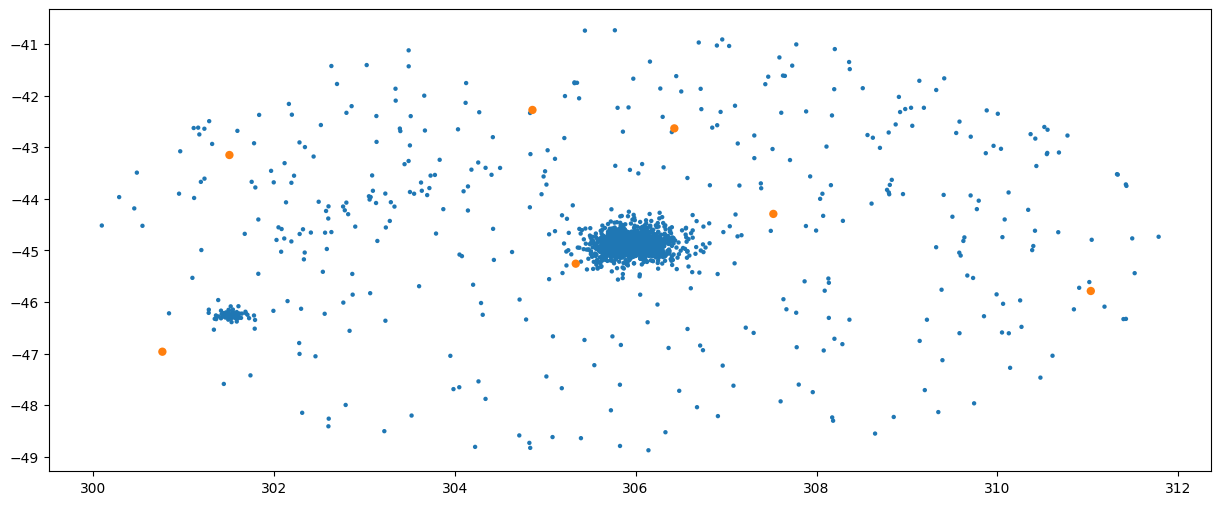

In [156]:

mask = (np.abs(df.pmra - 5.23) < df.pmra_error * df.pmra) & (np.abs(df.pmdec + 2.54) < df.pmdec_error * df.pmdec.abs()) & (np.abs(df.parallax - 0.27) < df.parallax_error * df.parallax)
mask_hv = np.sqrt(df.pmra** 2 + df.pmdec**2) > 56

print(f"DF: {df[mask].shape[0]} elementos")
print(f"DF HV: {df[mask_hv].shape[0]} elementos")

#Representamos las estrellas en sus coordenadas galacticas

fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(df[mask].l.values, df[mask].b.values, s=10, edgecolor='none', label="test")
plt.scatter(df[mask_hv].l.values, df[mask_hv].b.values, edgecolor='none', label="test_hv")

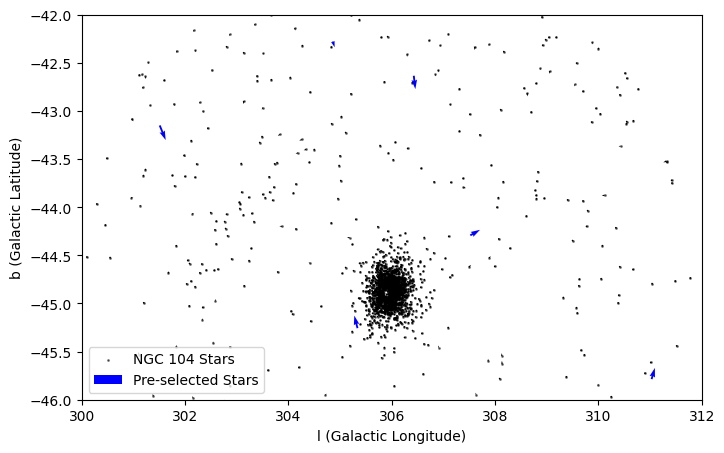

In [159]:
fig, ax = plt.subplots(figsize=(8, 5))

factor = 500

# Graficar las posiciones de las estrellas del cúmulo
ax.scatter(df[mask].l, df[mask].b, s=1, color="black", alpha=0.5, label="NGC 104 Stars")

# Graficar vectores de movimiento propio
ax.quiver(df[mask].l, df[mask].b, df[mask].pm_l / factor, df[mask].pm_b / factor, color="black", scale=5, width=0.003)

# Marcar las estrellas seleccionadas (ejemplo: aquellas con ciertas condiciones)
selected = df[mask_hv]  # Filtrar por una condición específica

ax.quiver(selected["l"], selected["b"], selected["pm_l"] / factor, selected["pm_b"] / factor,
          color="blue", scale=5, width=0.003, label="Pre-selected Stars")


# Etiquetas y detalles
ax.set_xlabel("l (Galactic Longitude)")
ax.set_ylabel("b (Galactic Latitude)")
ax.set_xlim(300, 312)
ax.set_ylim(-46, -42)
ax.legend()
plt.show()

In [139]:
vel_l, vel_b = get_l_b_velocities(df.pmra, df.pmdec, df.l, df.b, df.parallax)
df.loc[:, "vel_l"] = vel_l
df.loc[:, "vel_b"] = vel_b

In [150]:
selected["pm_l"]

12017    -10.362819
19480    -48.190183
27144     13.227321
35287     18.837281
43551    -16.026377
53079     24.001705
89570     39.047776
105226   -12.963785
153490    -7.837745
260349   -43.421720
268827   -48.040614
269250     7.535103
348057     6.306062
Name: pm_l, dtype: float64